In [498]:
#from __future__ import division, print_function
import sys
import os
#import json
import csv
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
#import seaborn
#from scipy.optimize import curve_fit, minimize
import pyproj
from pyproj import Proj, transform

import geopandas as gp
from fiona.crs import from_epsg
#import subprocess
import shapely as shp
from datetime import datetime
#from itertools import compress
from geopandas.tools import sjoin
from shapely.geometry import Point


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#### read raw monthly data, clean, append to years, write to file

In [3]:
cb_2013 = pd.DataFrame()
for m in list(compress(os.listdir('data_raw_cb'), [('cb_2013' in i) for i in os.listdir('data_raw_cb')])):
    cb_2013g = pd.read_csv('data_raw_cb/'+m)
    cb_2013 = cb_2013.append(cb_2013g, ignore_index = True)

In [5]:
# read in 2014 cb data
cb_2014 = pd.DataFrame()
for m in list(compress(os.listdir('data_raw_cb'), [('cb_2014' in i) for i in os.listdir('data_raw_cb')])):
    cb_2014g = pd.read_csv('data_raw_cb/'+m)
    cb_2014 = cb_2014.append(cb_2014g, ignore_index = True)

In [7]:
# read in 2015 cb data
cb_2015 = pd.DataFrame()
for m in list(compress(os.listdir('data_raw_cb'), [('cb_2015' in i) for i in os.listdir('data_raw_cb')])):
    cb_2015g = pd.read_csv('data_raw_cb/'+m)
    cb_2015 = cb_2015.append(cb_2015g, ignore_index = True)

In [21]:
# read in 2016 cb data (to 9/2016)
cb_2016 = pd.DataFrame()
for m in list(compress(os.listdir('data_raw_cb'), [('cb_2016' in i) for i in os.listdir('data_raw_cb')])):
    cb_2016a = pd.read_csv('data_raw_cb/'+m)
    cb_2016 = cb_2016.append(cb_2016a, ignore_index = True)
    


In [48]:
def ren(data):
    new_names = data.rename(columns={"Trip Duration":"tripduration",
                                     "Start Time":"starttime",
                                     "Stop Time":"stoptime",
                                     "Start Station ID":"start station id",
                                     "Start Station Name":"start station name",
                                     "Start Station Latitude":"start station latitude",
                                     "Start Station Longitude":"start station longitude",
                                     "End Station ID":"end station id",
                                     "End Station Name":"end station name",
                                     "End Station Latitude":"end station latitude",
                                     "End Station Longitude":"end station longitude",
                                     "Bike ID":"bikeid",
                                     "User Type":"usertype",
                                     "Birth Year":"birth year",
                                     "Gender":"gender"}
                           )
    return new_names

In [ ]:
# read in 2016 cb data (10/2016 to 12/2016)


cb_201610x = pd.read_csv('data_raw_cb/cb_x_201610.csv')
cb_201610 = ren(cb_201610x)
cb_201610.to_csv('data_raw_cb/cb_201610.csv')

cb_201611x = pd.read_csv('data_raw_cb/cb_x_201611.csv')
cb_201611 = ren(cb_201611x)
cb_201611.to_csv('data_raw_cb/cb_201611.csv')

cb_201612x = pd.read_csv('data_raw_cb/cb_x_201612.csv')
cb_201612 = ren(cb_201612x)
cb_201612.to_csv('data_raw_cb/cb_201612.csv')

cb_2016 = cb_2016.append(cb_201610, ignore_index = True)
cb_2016 = cb_2016.append(cb_201611, ignore_index = True)
cb_2016 = cb_2016.append(cb_201612, ignore_index = True)
                       

In [55]:
# read in 2017 cb data (Jan to March)

cb_2017 = pd.DataFrame()
for m in list(compress(os.listdir('data_raw_cb'), [('cb_2017' in i) for i in os.listdir('data_raw_cb')])):
    cb_2017g = pd.read_csv('data_raw_cb/'+m)
    cb_2017 = cb_2017.append(cb_2017g, ignore_index = True)
    
cb_2017 = ren(cb_2017)

In [54]:
# write clean yearly raw data to files

cb_2014.to_csv('data_raw_cb/cb_year_2014.csv')
cb_2015.to_csv('data_raw_cb/cb_year_2015.csv')
cb_2016.to_csv('data_raw_cb/cb_year_2016.csv')
cb_2017.to_csv('data_raw_cb/cb_year_2017.csv')

#### create station shapefiles (one with all new deployments as well as one for each year)

In [119]:
def crunch(cb_data_yearly):
    stations = cb_data_yearly[['start station id','starttime','start station latitude','start station longitude']]
    stations.rename(columns={'start station id':'station_id',
                                'starttime':'deployment',
                                'start station latitude':'lat',
                                'start station longitude':'lon',
                                },
                      inplace = True)
    stations['date_temp'] = pd.to_datetime(stations['deployment'])
    stations = stations.sort_values(by='date_temp')
    stations.drop_duplicates(subset='station_id',keep ='first', inplace = True)
    #stations.drop(['date_temp'],inplace=True,axis=1)
    return stations

In [ ]:
cb_2013_stations = crunch(cb_2013)
cb_2014_stations = crunch(cb_2014)
cb_2015_stations = crunch(cb_2015)
cb_2016_stations = crunch(cb_2016)
cb_2017_stations = crunch(cb_2017)

In [155]:
cb_2013_to_2014_stations = cb_2013_stations.append(cb_2014_stations, ignore_index=True)
#cb_2013_to_2014_stations['date_temp'] = cb_2013_to_2014_stations(cb_2013_2014['deployment'])
cb_2013_to_2014_stations = cb_2013_to_2014_stations.sort_values(by='date_temp')
cb_2013_to_2014_stations.drop_duplicates(subset='station_id',keep ='first',inplace=True)
len(cb_2013_to_2014_stations)

In [158]:
cb_2013_to_2015_stations = cb_2013_to_2014_stations.append(cb_2015_stations, ignore_index=True)
#cb_2013_to_2015_stations['date_temp'] = pd.to_datetime(cb_2013_to_2015_stations['deployment'])
cb_2013_to_2015_stations = cb_2013_to_2015_stations.sort_values(by='date_temp')
cb_2013_to_2015_stations.drop_duplicates(subset='station_id',keep ='first',inplace=True)
len(cb_2013_to_2015_stations)

In [163]:
cb_2013_to_2016_stations = cb_2013_to_2015_stations.append(cb_2016_stations,ignore_index=True)
#cb_2013_to_2016_stations['date_temp'] = pd.to_datetime(cb_2013_to_2016_stations['deployment'])
cb_2013_to_2016_stations = cb_2013_to_2016_stations.sort_values(by='date_temp')
cb_2013_to_2016_stations.drop_duplicates(subset='station_id',keep ='first',inplace=True)
len(cb_2013_to_2016_stations)

In [176]:
new_cb_stations = cb_2013_to_2016_stations.append(cb_2017_stations,ignore_index=True)
#new_cb_stations['date_temp'] = pd.to_datetime(new_cb_stations['deployment'])
new_cb_stations = new_cb_stations.sort_values(by='date_temp')
new_cb_stations.drop_duplicates(subset='station_id',keep ='first',inplace=True)
len(new_cb_stations)

677

In [201]:
# prepare boro shapefiles for plotting

boro_shapes_feet= gp.GeoDataFrame.from_file("data/boro_shapes.shp")
boro_shapes_feet.crs = {'init': 'epsg:2263', 'no_defs': True}
boro_shapes_feet = boro_shapes_feet.to_crs(epsg=2263)
boro_shapes_feet.crs

{'init': 'epsg:2263', 'no_defs': True}

In [ ]:
crs = {'init': 'epsg:4326', 'no_defs': True}
geometry = [Point(xy) for xy in zip(new_cb_stations['lon'], new_cb_stations['lat'])]    
new_cb_stations = gp.GeoDataFrame(new_cb_stations, geometry = geometry, crs=crs)
new_cb_stations = new_cb_stations.to_crs(epsg=2263)

data_merged_g = sjoin(new_cb_stations, boro_shapes_feet, how='inner', op='within')
data_merged_g.reset_index(drop=True, inplace=True)
data_merged_g.drop(['index_right'],inplace=True,axis=1)

# bad brooklyn stations: 3239, 3245, 3040, 255
# bad Manhattan stations: 3036, 3182, 3254, 3181

for i in (3239, 3245, 3040, 255,3036, 3182, 3254, 3181):
    data_merged_g = data_merged_g[data_merged_g.station_id != i]
new_cb_stations = data_merged_g

In [488]:
new_cb_stations_2013 = new_cb_stations[new_cb_stations.date_temp.dt.year ==2013] 
new_cb_stations_2014 = new_cb_stations[new_cb_stations.date_temp.dt.year ==2014] 
new_cb_stations_2015 = new_cb_stations[new_cb_stations.date_temp.dt.year ==2015] 
new_cb_stations_2016 = new_cb_stations[new_cb_stations.date_temp.dt.year ==2016] 
new_cb_stations_2017 = new_cb_stations[new_cb_stations.date_temp.dt.year ==2017] 

In [489]:
new_cb_stations.drop(['date_temp'],inplace=True,axis=1)
new_cb_stations_2013.drop(['date_temp'],inplace=True,axis=1)
new_cb_stations_2014.drop(['date_temp'],inplace=True,axis=1)
new_cb_stations_2015.drop(['date_temp'],inplace=True,axis=1)
new_cb_stations_2016.drop(['date_temp'],inplace=True,axis=1)
new_cb_stations_2017.drop(['date_temp'],inplace=True,axis=1)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__ma

In [495]:
# shapefiles

new_cb_stations.crs.to_file('data_pre_cb/new_cb_stations.shp')
new_cb_stations_2013.crs.to_file('data_pre_cb/new_cb_stations_2013.shp')
new_cb_stations_2014.crs.to_file('data_pre_cb/new_cb_stations_2014.shp')
new_cb_stations_2015.crs.to_file('data_pre_cb/new_cb_stations_2015.shp')
new_cb_stations_2016.crs.to_file('data_pre_cb/new_cb_stations_2016.shp')
new_cb_stations_2017.crs.to_file('data_pre_cb/new_cb_stations_2017.shp')

In [496]:
# csv's

new_cb_stations.to_csv('data_pre_cb/new_cb_stations_csv.csv')
new_cb_stations_2013.to_csv('data_pre_cb/new_cb_stations_2013_csv.csv')
new_cb_stations_2014.to_csv('data_pre_cb/new_cb_stations_2014_csv.csv')
new_cb_stations_2015.to_csv('data_pre_cb/new_cb_stations_2015_csv.csv')
new_cb_stations_2016.to_csv('data_pre_cb/new_cb_stations_2016_csv.csv')
new_cb_stations_2017.to_csv('data_pre_cb/new_cb_stations_2017_csv.csv')

#### Plot (just to take a look)

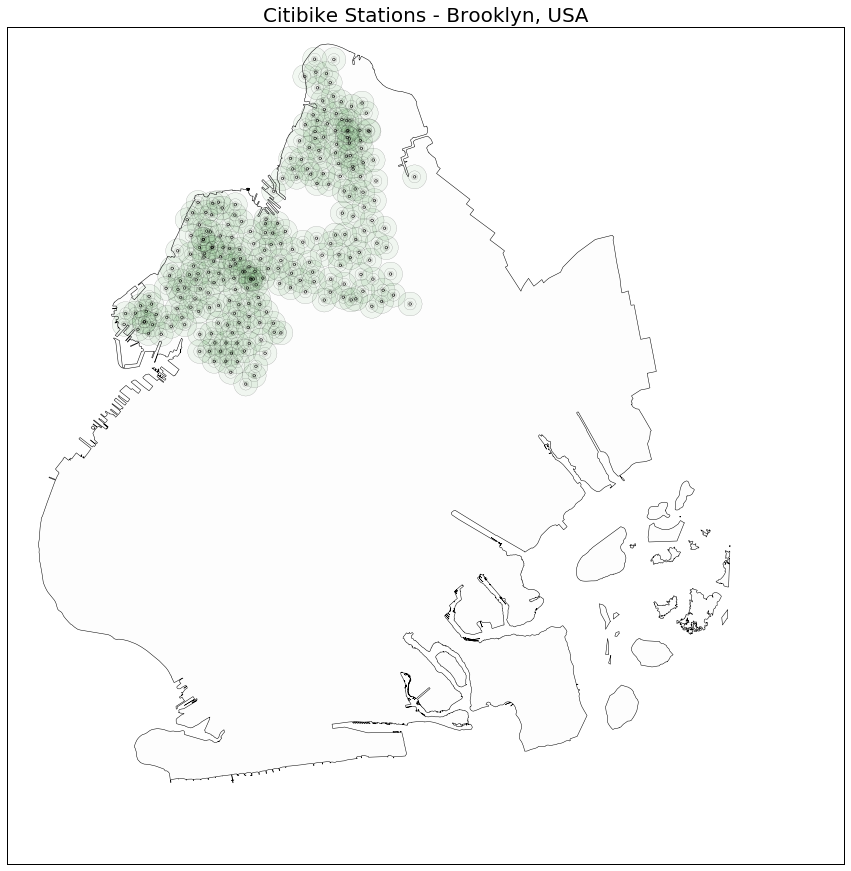

In [421]:
bn1 = 'Brooklyn'
bn2 = 'Manhattan'
bn3 = 'Queens'

f, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#boro_shapes.plot(column='boro_name',alpha=.05,color='grey',linewidth=0.5,ax=ax)
boro_shapes[boro_shapes.boro_name == bn1].plot(column='boro_name',alpha=.01,color='grey',linewidth=0.5,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn1].geometry.buffer(100).plot(alpha=2,color='white',label = 'Stations 100', linewidth=0.5,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn1].geometry.buffer(150).plot(alpha=.1,color='white',label = 'Stations 150', linewidth=0.1,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn1].geometry.buffer(250).plot(alpha=.01,color='red',label = 'Stations 200', linewidth=0.1,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn1].geometry.buffer(500).plot(alpha=.3,color='white',label = 'Stations 500', linewidth=0.1,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn1].geometry.buffer(1000).plot(alpha=.05,color='green',label = 'Stations 1000', linewidth=0.1,ax=ax)


plt.title("Citibike Stations - Brooklyn, USA", fontsize = 20)

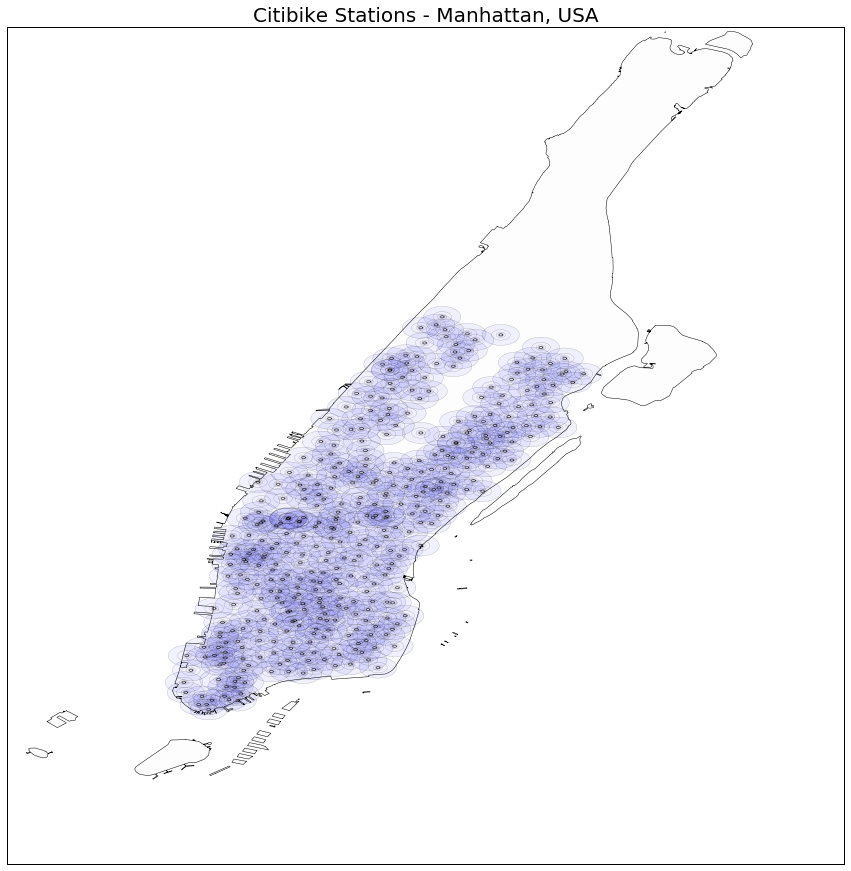

In [423]:
bn1 = 'Brooklyn'
bn2 = 'Manhattan'
bn3 = 'Queens'

f, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#boro_shapes.plot(column='boro_name',alpha=.05,color='grey',linewidth=0.5,ax=ax)
boro_shapes[boro_shapes.boro_name == bn2].plot(column='boro_name',alpha=.01,color='grey',linewidth=0.5,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn2].geometry.buffer(100).plot(alpha=2,color='white',label = 'Stations 100', linewidth=0.5,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn2].geometry.buffer(150).plot(alpha=.1,color='white',label = 'Stations 150', linewidth=0.1,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn2].geometry.buffer(250).plot(alpha=.01,color='red',label = 'Stations 250', linewidth=0.1,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn2].geometry.buffer(500).plot(alpha=.3,color='white',label = 'Stations 500', linewidth=0.1,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn2].geometry.buffer(1000).plot(alpha=.05,color='blue',label = 'Stations 1000', linewidth=0.1,ax=ax)

plt.title("Citibike Stations - Manhattan, USA", fontsize = 20)


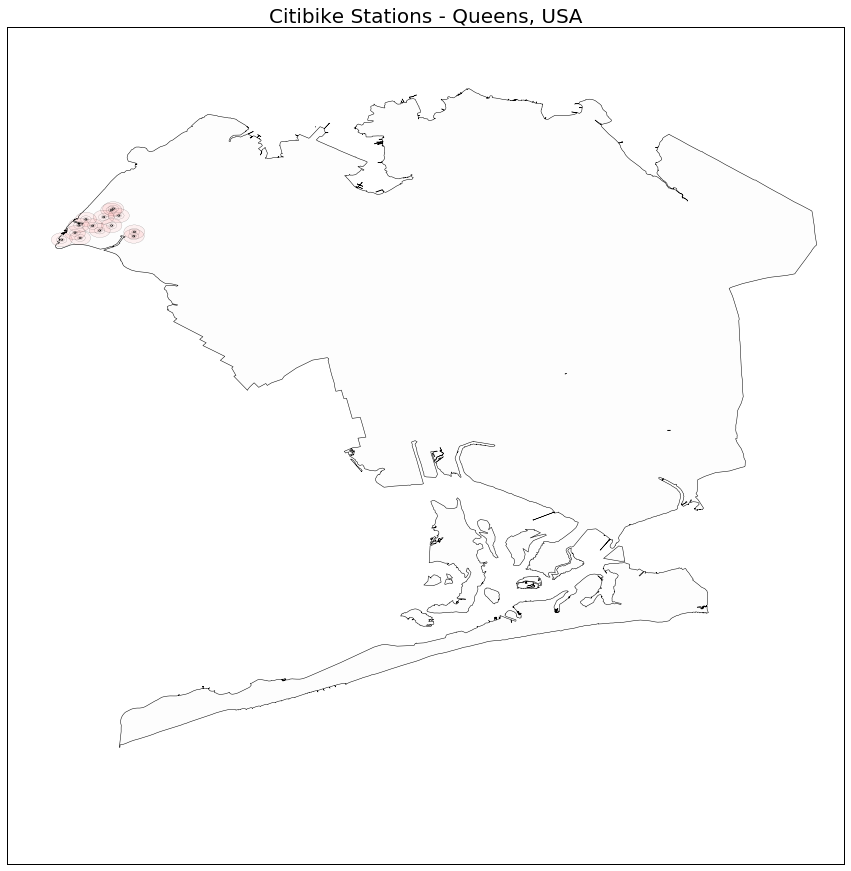

In [424]:
bn1 = 'Brooklyn'
bn2 = 'Manhattan'
bn3 = 'Queens'

f, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#boro_shapes.plot(column='boro_name',alpha=.05,color='grey',linewidth=0.5,ax=ax)
boro_shapes[boro_shapes.boro_name == bn3].plot(column='boro_name',alpha=.01,color='grey',linewidth=0.5,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn3].geometry.buffer(100).plot(alpha=2,color='white',label = 'Stations 100', linewidth=0.5,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn3].geometry.buffer(150).plot(alpha=.1,color='white',label = 'Stations 150', linewidth=0.1,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn3].geometry.buffer(250).plot(alpha=.01,color='red',label = 'Stations 250', linewidth=0.1,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn3].geometry.buffer(500).plot(alpha=.3,color='white',label = 'Stations 500', linewidth=0.1,ax=ax)
new_cb_stations[new_cb_stations.boro_name == bn3].geometry.buffer(1000).plot(alpha=.05,color='red',label = 'Stations 1000', linewidth=0.1,ax=ax)

plt.title("Citibike Stations - Queens, USA", fontsize = 20)